# Spectral fitting example

**To run this, you need FlatContinuumIsotropic.LowRes.binnedimaging.imagingresponse.area.nside8.cosipy.h5.zip in cosipy/cosipy/test_data. To fit the megalib simulation, you need grb_bkg_binned_data.hdf5, grb_binned_data.hdf5, & bkg_binned_data.hdf5 in cosipy/docs/tutorials/data, and to fit the source injector data, you need GRBdata.h5, GRBsignal.h5, and GRBbkg.h5 in cosipy/docs/tutorials/data.**

The goal of this notebook is to get familiar with 3ML and get a concrete idea on the spectral fitting will work. 

[3ML](https://threeml.readthedocs.io/) is a high-level interface that allows multiple dataset form different instruments to be used coherently to fit the parameters of source model. A source model typically consists on a list of sources with a parametrized spectral shapes, sky locations and, for extended sources, shape. Polarization is also possible. A "coherent" analysis, in this context, means that the source model parameters are fitted using all available datasets simultanously, rather than performing individual fits and finding a well-suited common model a posteriori. 

In order for a dataset to be included in 3ML, each instrument needs to provide a "plugin". Each plugin is responsible for reading the data, convolving the source model (provided by 3ML) with the instrument response, and returning a likelihood. In our case, we'll compute a binned Poisson likelihood:

$$
\log \mathcal{L}(\mathbf{x}) = \sum_i \log \frac{\lambda_i(\mathbf{x})^{d_i} \exp (-\lambda_i)}{d_i!}
$$

where $d_i$ are the counts on each bin and $\lambda_i$ are the _expected_ counts, given a source model with parameters $\mathbf{x}$. 

In this example, we will fit a single point source with a known location. We'll assume the background is known and fixed. Finally, we will fit a power law:

$$
F(E) = K \left(\frac{E}{E_{piv}}\right)^{-index}
$$


where $K$ (normalization) and the spectral index are the only free parameters, while $E_{piv}$ is the pivot energy which is fixed (and arbitrary).

Considering these assumptions:

$$
\lambda_i(\mathbf{x}) = b_i + s_i(\mathbf{x}) = b_i + s_i(\mathrm{norm}, \mathrm{index})
$$

where $b_i$ are the estimated counts due to background on each bin, and $s_i$ are the corresponding expected counts from the source.

The goal is then to find the values of $\mathbf{x} = [\mathrm{norm}, \mathrm{index}]$ that maximize $\mathcal{L}$. These are the best estimation of the parameters.

The final module needs to also fit the background, handle multiple point-like and extended sources, as well as all the spectral models supported by 3ML. Eventually, it will also fit the polarization angle. However, this simple example already contains all the necessary pieces to do a fit.

In [38]:
from cosipy import COSILike, test_data, BinnedData
from cosipy.coordinates.orientation import Orientation_file
from scoords import SpacecraftFrame, Attitude

from histpy import Histogram

from astropy.time import Time
import astropy.units as u

import numpy as np
import matplotlib.pyplot as plt

from threeML import Powerlaw, Band, PointSource, Model, JointLikelihood, DataList
from astromodels import Parameter

## Read in data (megalib simulation)

Read in the spacecraft orientation file & select times for GRB

In [46]:
ori = Orientation_file.parse_from_file("data/20280301_first_2hrs.ori")
Timemin = Time(1835481433.0,format = 'unix')
Timemax = Time(1835481435.0,format = 'unix')
sc_orientation_grb = ori.source_interval(Timemin, Timemax)

Create BinnedData objects for the Crab only, Crab+background, and background only

In [98]:
crab = BinnedData("data/crab.yaml")
#crab_bkg = BinnedData("data/background.yaml")
bkg = BinnedData("data/background.yaml")
grb = BinnedData("data/grb.yaml")
full = BinnedData("data/background.yaml")
full_grb = BinnedData("data/grb.yaml")

Read in .tra files for the Crab & background. This does not need to be done if you already have .hdf5 files

In [19]:
# crab.read_tra(output_name="data/crab_unbinned_data")
# bkg.read_tra(output_name="data/bkg_unbinned_data")

Combine unbinned Crab & background .hdf5 files. This does not need to be done if you already have a combined .hdf5 file

In [43]:
# full.combine_unbinned_data(["data/grb_unbinned_data.hdf5","data/crab_unbinned_data.hdf5","data/bkg_unbinned_data.hdf5"], output_name="data/full_unbinned_data")


adding data/grb_unbinned_data.hdf5...


adding data/crab_unbinned_data.hdf5...


adding data/bkg_unbinned_data.hdf5...



In [99]:
# full_grb.select_data(unbinned_data="data/full_unbinned_data.hdf5", output_name="data/full_selected_unbinned_data")

Making data selections...


Bin Crab only, Crab+background, and background only files. This does not need to be done if you already have binned .hdf5 files

binning data...

Note: time bins must be equally spaced between min and max time.
Using time bin size [s]: 0.5


PsiChi binning:
Approximate resolution at NSIDE 8 is 7.3 deg



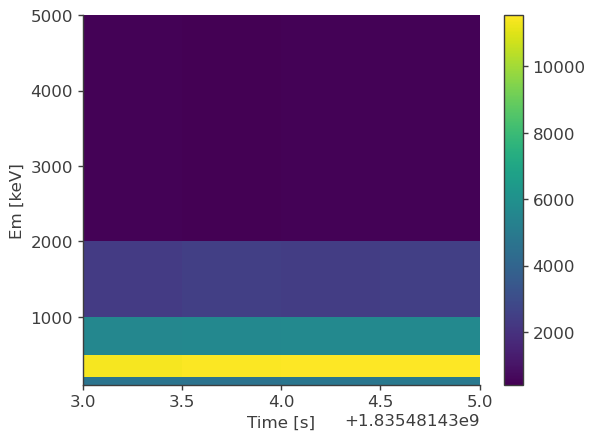

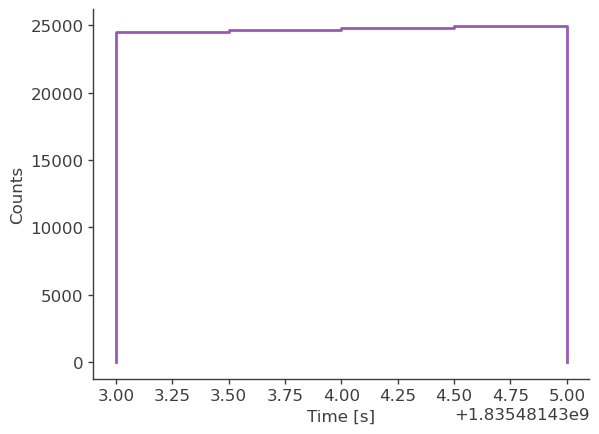

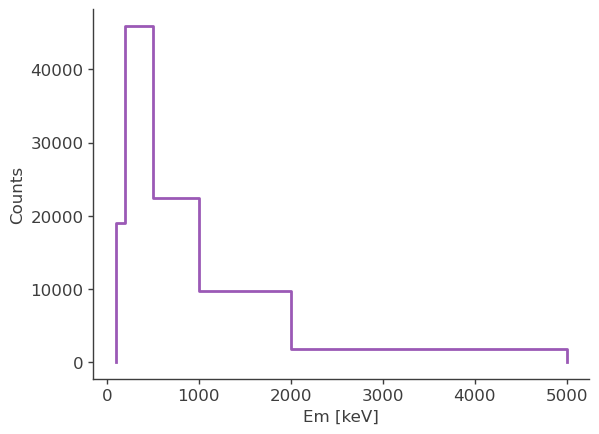

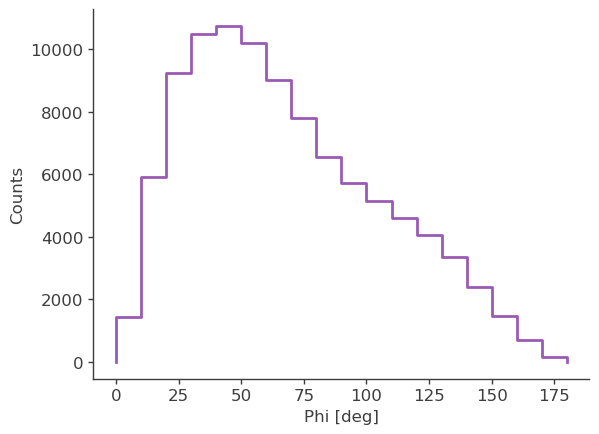

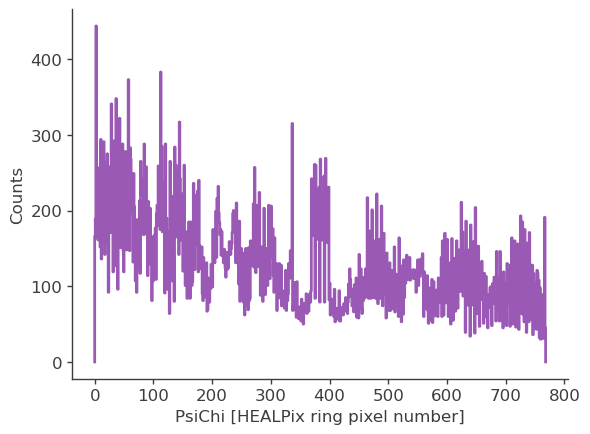

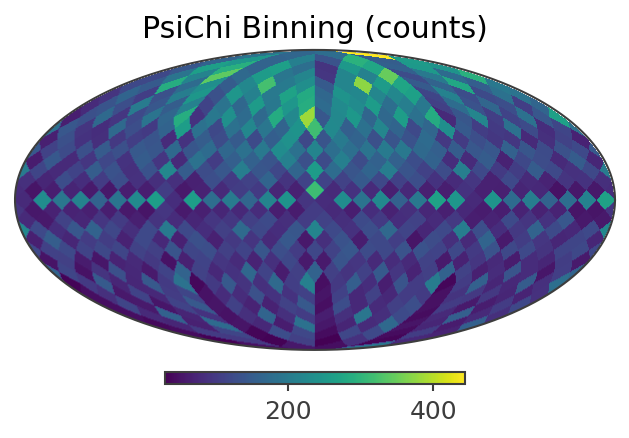

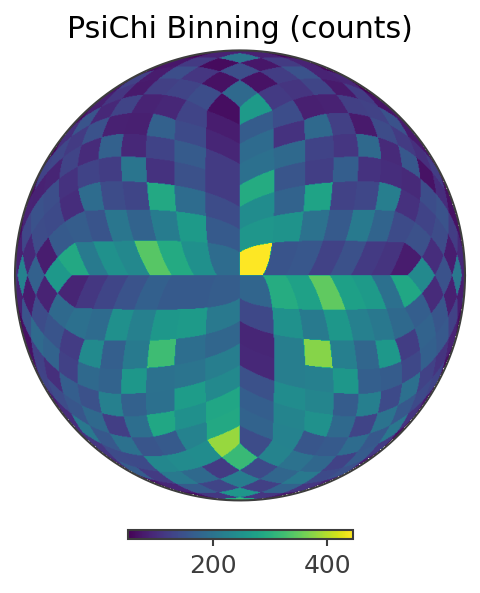

In [101]:
# grb.get_binned_data(unbinned_data="data/grb_unbinned_data.hdf5", make_binning_plots=True, output_name="data/grb_binned_data")
# crab.get_binned_data(unbinned_data="data/crab_unbinned_data.hdf5", make_binning_plots=True, output_name="data/crab_binned_data")
# crab_bkg.get_binned_data(unbinned_data="data/crab_bkg_unbinned_data.hdf5", make_binning_plots=True, output_name="data/crab_bkg_binned_data_grbtime")
# bkg.get_binned_data(unbinned_data="data/bkg_unbinned_data.hdf5", make_binning_plots=True, output_name="data/bkg_binned_data")
# full.get_binned_data(unbinned_data="data/full_unbinned_data.hdf5", make_binning_plots=True, output_name="data/full_binned_data")
# full_grb.get_binned_data(unbinned_data="data/full_selected_unbinned_data.hdf5", make_binning_plots=True, output_name="data/full_selected_binned_data")

Create spectra and lightcurves for Crab only, Crab+background, and background only

getting raw spectrum...


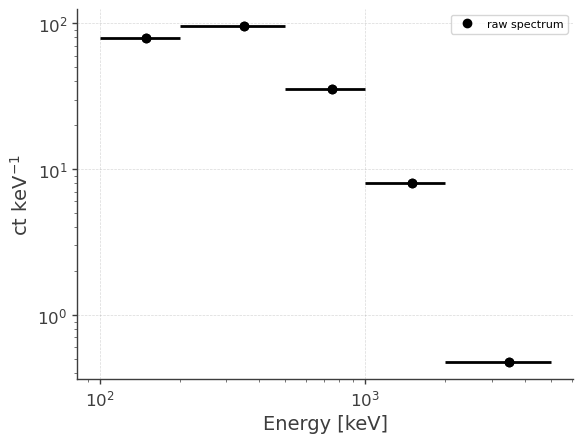

getting raw lightcurve...


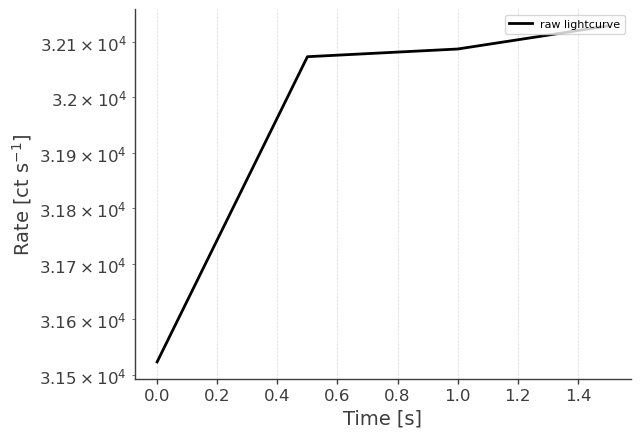

getting raw spectrum...


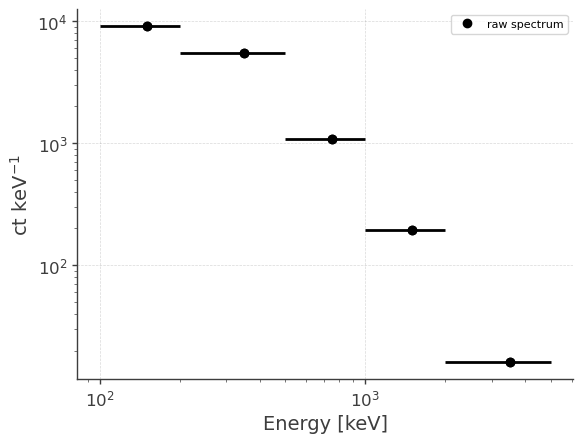

getting raw lightcurve...


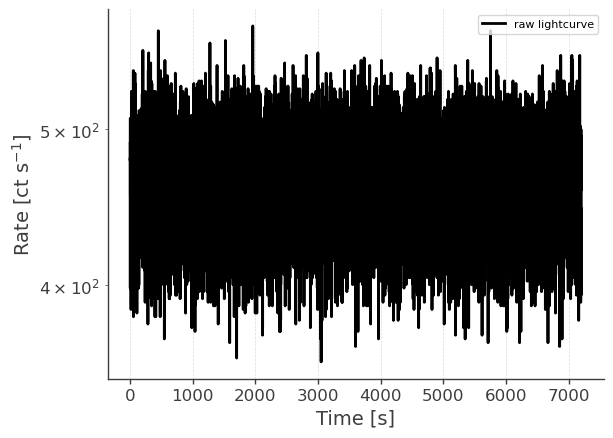

getting raw spectrum...


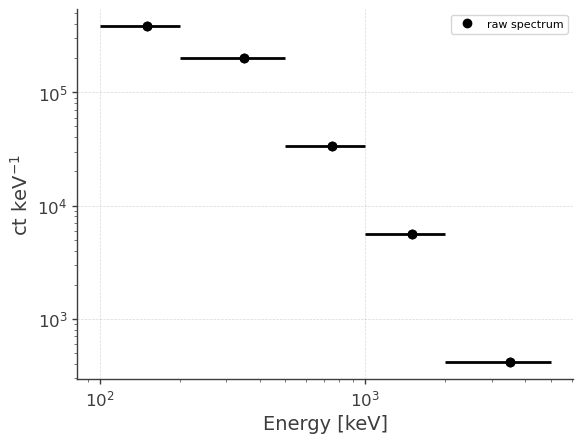

getting raw lightcurve...


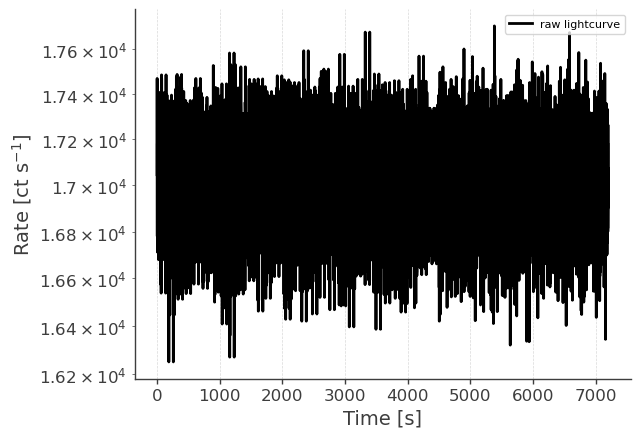

getting raw spectrum...


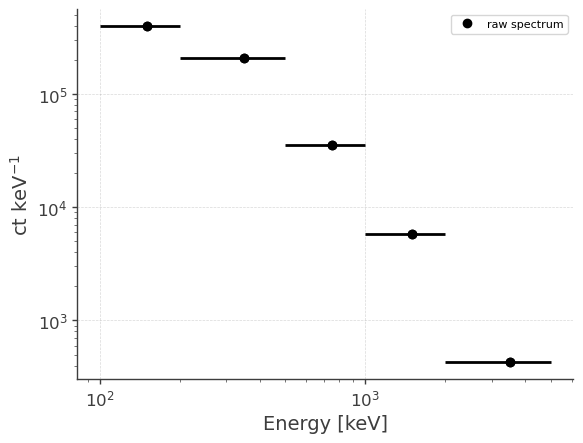

getting raw lightcurve...


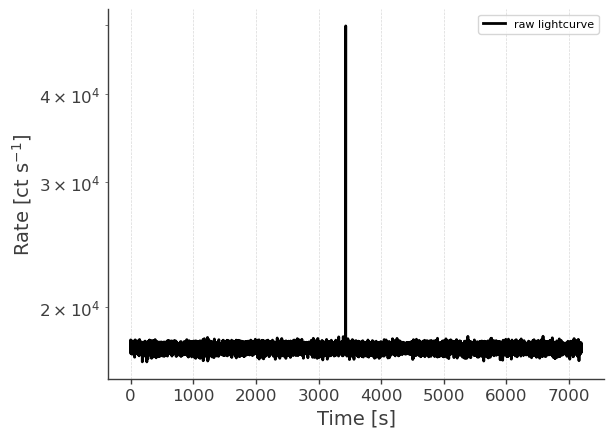

In [45]:
grb.get_raw_spectrum(binned_data="data/grb_binned_data.hdf5", output_name="data/grb_sp")
grb.get_raw_lightcurve(binned_data="data/grb_binned_data.hdf5", output_name="data/grb_lc")
crab.get_raw_spectrum(binned_data="data/crab_binned_data.hdf5", output_name="data/crab_sp")
crab.get_raw_lightcurve(binned_data="data/crab_binned_data.hdf5", output_name="data/crab_lc")
# crab_bkg.get_raw_spectrum(binned_data="data/crab_bkg_binned_data.hdf5", output_name="data/crab_bkg_sp")
# crab_bkg.get_raw_lightcurve(binned_data="data/crab_bkg_binned_data.hdf5", output_name="data/crab_bkg_lc")
bkg.get_raw_spectrum(binned_data="data/bkg_binned_data.hdf5", output_name="data/bkg_sp")
bkg.get_raw_lightcurve(binned_data="data/bkg_binned_data.hdf5", output_name="data/bkg_lc")
grb.get_raw_spectrum(binned_data="data/full_binned_data.hdf5", output_name="data/full_sp")
grb.get_raw_lightcurve(binned_data="data/full_binned_data.hdf5", output_name="data/full_lc")

Load binned .hdf5 files if you already have them

In [102]:
grb.load_binned_data_from_hdf5(binned_data="data/grb_binned_data.hdf5")
crab.load_binned_data_from_hdf5(binned_data="data/crab_binned_data.hdf5")
# crab_bkg.load_binned_data_from_hdf5(binned_data="data/crab_bkg_binned_data_grbtime.hdf5")
bkg.load_binned_data_from_hdf5(binned_data="data/bkg_binned_data.hdf5")
full.load_binned_data_from_hdf5(binned_data="data/full_binned_data.hdf5")
full_grb.load_binned_data_from_hdf5(binned_data="data/full_selected_binned_data.hdf5")

## Perform spectral fit (megalib simulation)

Define inputs needed by COSI plugin, optionally set background parameter (fits amplitude of background), and instantiate threeML plugin

In [120]:
dr = test_data.path / "FlatContinuumIsotropic.LowRes.binnedimaging.imagingresponse.area.nside8.cosipy.h5" # path to detector response

bkg_par = Parameter("background_cosi",                                        # background parameter
                    2.8e-4,                                                   # initial value of parameter
                    min_value=0,                                              # minimum value of parameter
                    max_value=5,                                              # maximum value of parameter
                    delta=0.05,                                               # initial step used by fitting engine
                    desc="Background parameter for cosi")

cosi = COSILike("cosi",                                                       # COSI 3ML plugin
                dr = dr,                                                      # detector response
                data = full_grb.binned_data.project('Em', 'Phi', 'PsiChi'),   # data 
                bkg = bkg.binned_data.project('Em', 'Phi', 'PsiChi'),         # background model 
                sc_orientation = sc_orientation_grb,                          # spacecraft orientation
                nuisance_param = bkg_par)                                     # background parameter

Define a point source at the known location with a power law spectrum and add it to the model

In [121]:
alpha = -1.                                     
beta = -3.
xp = 1000 * u.keV
piv = 500 * u.keV
K = 0.00247 / u.cm / u.cm / u.s / u.keV

spectrum_grb = Band(alpha=alpha,
                    beta=beta,
                    xp=xp.value,
                    K=K.value,
                    piv=piv.value)

spectrum_grb.xp.unit = xp.unit
spectrum_grb.K.unit = K.unit
spectrum_grb.piv.unit = piv.unit

spectrum_grb.xp.fix = True
spectrum_grb.K.fix = True

grb = PointSource("grb",                            # Name of source (arbitrary, but needs to be unique)
                  l = 51.,                          # Longitude (deg)
                  b = -17.,                         # Latitude (deg)
                  spectral_shape = spectrum_grb)    # Spectral model


grb_model = Model(grb)                              # Model with single source. If we had multiple sources, we would do Model(source1, source2, ...)

# Optional: if you want to call get_log_like manually, then you also need to set the model manually
# 3ML does this internally during the fit though
cosi.set_model(model)

Gather all plugins and combine with model in JointLikelihood object, then perform maximum likelihood fit

In [122]:
plugins = DataList(cosi) # If we had multiple instruments, we would do e.g. DataList(cosi, lat, hawc, ...)

grb_like = JointLikelihood(grb_model, plugins, verbose = False)

grb_like.fit()

16:32:12 INFO      set the minimizer to minuit                                             ]8;id=558707;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=896008;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: divide by zero encountered in log



16:32:14 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=975304;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=952297;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

Best fit values:

,result,unit
parameter,,
grb.spectrum.main.Band.alpha,(-7.89 +/- 0.09) x 10^-1,
grb.spectrum.main.Band.beta,-2.34 +/- 0.04,
background_cosi,(3.281 +/- 0.025) x 10^-4,


Correlation matrix:

1.00,0.13,0.55
0.13,1.00,0.01
0.55,0.01,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
cosi,-43306.574214
total,-43306.574214


Values of statistical measures:

,statistical measures
AIC,-86615.148429
BIC,-86613.148429


(                                 value  negative_error  positive_error  \
 grb.spectrum.main.Band.alpha -0.788685       -0.008899        0.008474   
 grb.spectrum.main.Band.beta  -2.337129       -0.036101        0.035306   
 background_cosi               0.000328       -0.000003        0.000002   
 
                                  error unit  
 grb.spectrum.main.Band.alpha  0.008687       
 grb.spectrum.main.Band.beta   0.035703       
 background_cosi               0.000003       ,
        -log(likelihood)
 cosi      -43306.574214
 total     -43306.574214)

In [125]:
bkg_par = Parameter("background_cosi",                                        # background parameter
                    1,                                                        # initial value of parameter
                    min_value=0,                                              # minimum value of parameter
                    max_value=5,                                              # maximum value of parameter
                    delta=0.05,                                               # initial step used by fitting engine
                    desc="Background parameter for cosi")

cosi = COSILike("cosi",                                                       # COSI 3ML plugin
                dr = dr,                                                      # detector response
                data = full.binned_data.project('Em', 'Phi', 'PsiChi'),       # data 
                bkg = bkg.binned_data.project('Em', 'Phi', 'PsiChi'),         # background model 
                sc_orientation = ori,                                         # spacecraft orientation
                nuisance_param = bkg_par)                                     # background parameter

In [126]:
index = -2.32
piv = 500 * u.keV
K = 1.56e-5 / u.cm / u.cm / u.s / u.keV

spectrum_crab = Powerlaw(index=index,
                         piv=piv.value,
                         K=K.value)

spectrum_crab.K.unit = K.unit
spectrum_crab.piv.unit = piv.unit

crab = PointSource("crab",                            # Name of source (arbitrary, but needs to be unique)
                   l = 184.56,                        # Longitude (deg)
                   b = -5.78,                         # Latitude (deg)
                   spectral_shape = spectrum_crab)    # Spectral model

crab_model = Model(crab)

In [127]:
plugins = DataList(cosi) # If we had multiple instruments, we would do e.g. DataList(cosi, lat, hawc, ...)

crab_like = JointLikelihood(crab_model, plugins, verbose = False)

crab_like.fit()

16:33:34 INFO      set the minimizer to minuit                                             ]8;id=821602;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=463154;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: divide by zero encountered in log



16:33:52 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=667549;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=387785;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

Best fit values:

,result,unit
parameter,,
crab.spectrum.main.Powerlaw.K,(6.68 +/- 0.08) x 10^-6,1 / (cm2 keV s)
crab.spectrum.main.Powerlaw.index,-1.841 +/- 0.008,
background_cosi,1.01672 +/- 0.00017,


Correlation matrix:

1.00,-0.35,-0.83
-0.35,1.00,0.42
-0.83,0.42,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
cosi,-9.313173e+08
total,-9.313173e+08


Values of statistical measures:

,statistical measures
AIC,-1.862635e+09
BIC,-1.862635e+09


(                                      value  negative_error  positive_error  \
 crab.spectrum.main.Powerlaw.K      0.000007   -7.850605e-08    8.497166e-08   
 crab.spectrum.main.Powerlaw.index -1.841055   -8.181531e-03    8.221908e-03   
 background_cosi                    1.016723   -1.734986e-04    1.674598e-04   
 
                                           error             unit  
 crab.spectrum.main.Powerlaw.K      8.173885e-08  1 / (cm2 keV s)  
 crab.spectrum.main.Powerlaw.index  8.201719e-03                   
 background_cosi                    1.704792e-04                   ,
        -log(likelihood)
 cosi      -9.313173e+08
 total     -9.313173e+08)

## 3ML error propagation and plotting (megalib simulation)

Define injected spectral parameters 

In [123]:
K_inj = 1.236       # 1/keV/cm2/s
piv_inj = 1.        # keV
alpha_inj = -1.
beta_inj = -3.
xp_inj = 1000.      # keV 

Best fit values:

,result,unit
parameter,,
grb.spectrum.main.Band.alpha,(-7.89 +/- 0.09) x 10^-1,
grb.spectrum.main.Band.beta,-2.34 +/- 0.04,
background_cosi,(3.281 +/- 0.025) x 10^-4,


Correlation matrix:

1.00,0.13,0.55
0.13,1.00,0.01
0.55,0.01,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
cosi,-43306.574214
total,-43306.574214


Values of statistical measures:

,statistical measures
AIC,-86615.148429
BIC,-86613.148429


None
  * grb (point source):
    * position:
      * l:
        * value: 51.0
        * desc: Galactic longitude
        * min_value: 0.0
        * max_value: 360.0
        * unit: deg
        * is_normalization: false
      * b:
        * value: -17.0
        * desc: Galactic latitude
        * min_value: -90.0
        * max_value: 90.0
        * unit: deg
        * is_normalization: false
      * equinox: J2000
    * spectrum:
      * main:
        * Band:
          * K:
            * value: 0.0024700000000000004
            * desc: Differential flux at the pivot energy
            * min_value: 1.0e-99
            * max_value: null
            * unit: keV-1 s-1 cm-2
            * is_normalization: true
          * alpha:
            * value: -0.788684690528293
            * desc: low-energy photon index
            * min_value: -1.5
            * max_value: 3.0
            * unit: ''
            * is_normalization: false
          * xp:
            * value: 1000.0
            * desc:

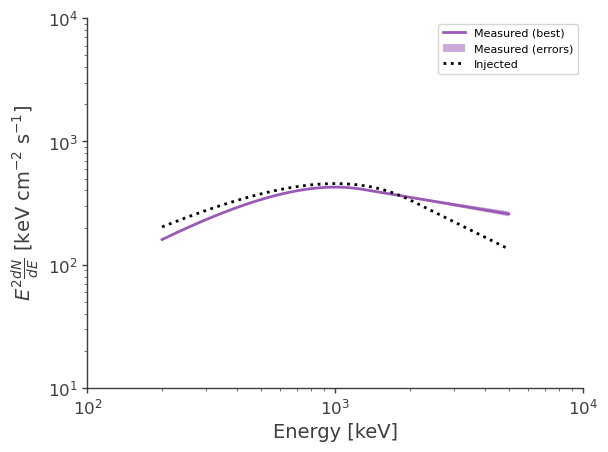

In [124]:
# Propagate the errors to the "evaluate_at" method of the spectrum
results = grb_like.results

print(results.display())

parameters = {par.name:results.get_variates(par.path)
              for par in results.optimized_model["grb"].parameters.values()
              if par.free}

if 'l' in parameters:
    del parameters['l']
if 'b' in parameters:
    del parameters['b']
if 'ra' in parameters:
    del parameters['ra']
if 'dec' in parameters:
    del parameters['dec']

results_err = results.propagate(results.optimized_model["grb"].spectrum.main.shape.evaluate_at, **parameters)

print(results.optimized_model["grb"])

# Evaluate at multiple energy values, for plotting
energy = np.geomspace(200*u.keV,5*u.MeV).to_value(u.keV)

flux_lo = np.zeros_like(energy)
flux_median = np.zeros_like(energy)
flux_hi = np.zeros_like(energy)

for i, e in enumerate(energy):
    flux = results_err(e)
    flux_median[i] = flux.median
    flux_lo[i], flux_hi[i] = flux.equal_tail_interval(cl=0.68)
    
# Plot
fig,ax = plt.subplots()

ax.plot(energy, energy*energy*flux_median, label = "Measured (best)")

ax.fill_between(energy, energy*energy*flux_lo, energy*energy*flux_hi, alpha = .5, label = "Measured (errors)")

# Plot injected spectrum
def band_megalib(energy, alpha, beta, E0):
    if energy == 0 or alpha - beta < 0:
        return 0.0
    else:
        ebreak = (alpha - beta) * E0
        if energy <= ebreak:
            return energy**alpha * np.exp(-energy/E0)
        else:
            return ebreak**(alpha-beta) * np.exp(beta-alpha) * energy**beta

flux_inj = np.zeros_like(energy)

for i, e in enumerate(energy):
    flux_inj[i] = K_inj * band_megalib(e, alpha_inj, beta_inj, xp_inj)
ax.plot(energy, energy*energy*flux_inj, color = 'black', ls = ":", label = "Injected")

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlim(1e2, 1e4)
ax.set_ylim(10, 1e4)

ax.set_xlabel("Energy [keV]")
ax.set_ylabel(r"$E^2 \frac{dN}{dE}$ [keV cm$^{-2}$ s$^{-1}$]")

ax.legend()

In [128]:
K_inj = 7.559e-4       # 1/keV/cm2/s
piv_inj = 100.         # keV
alpha_inj = -1.99
beta_inj = -2.32
xp_inj = 5.31          # keV 

The summary of the results above tell you the optimal values of the parameters, as well as the errors. You typically want to propagate these into the error in the flux at different energies, and plot the spectrum. Let's do that:

Best fit values:

,result,unit
parameter,,
crab.spectrum.main.Powerlaw.K,(6.68 +/- 0.08) x 10^-6,1 / (cm2 keV s)
crab.spectrum.main.Powerlaw.index,-1.841 +/- 0.008,
background_cosi,1.01672 +/- 0.00017,


Correlation matrix:

1.00,-0.35,-0.83
-0.35,1.00,0.42
-0.83,0.42,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
cosi,-9.313173e+08
total,-9.313173e+08


Values of statistical measures:

,statistical measures
AIC,-1.862635e+09
BIC,-1.862635e+09


None
  * crab (point source):
    * position:
      * l:
        * value: 184.56
        * desc: Galactic longitude
        * min_value: 0.0
        * max_value: 360.0
        * unit: deg
        * is_normalization: false
      * b:
        * value: -5.78
        * desc: Galactic latitude
        * min_value: -90.0
        * max_value: 90.0
        * unit: deg
        * is_normalization: false
      * equinox: J2000
    * spectrum:
      * main:
        * Powerlaw:
          * K:
            * value: 6.684603500686392e-06
            * desc: Normalization (differential flux at the pivot value)
            * min_value: 1.0e-30
            * max_value: 1000.0
            * unit: keV-1 s-1 cm-2
            * is_normalization: true
          * piv:
            * value: 500.0
            * desc: Pivot value
            * min_value: null
            * max_value: null
            * unit: keV
            * is_normalization: false
          * index:
            * value: -1.8410548367065314
    

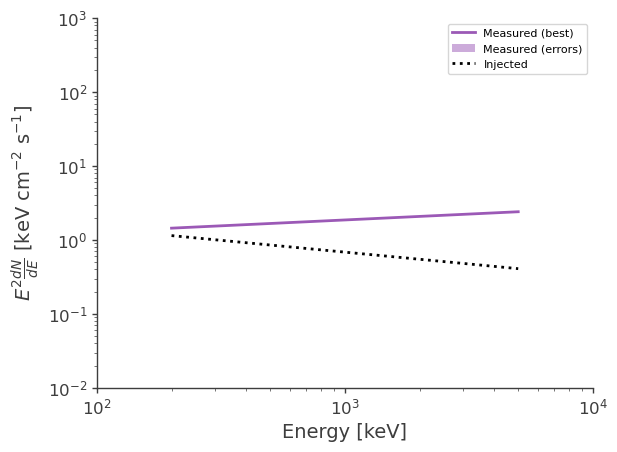

In [129]:
# Propagate the errors to the "evaluate_at" method of the spectrum
results = crab_like.results

print(results.display())

parameters = {par.name:results.get_variates(par.path)
              for par in results.optimized_model["crab"].parameters.values()
              if par.free}

if 'l' in parameters:
    del parameters['l']
if 'b' in parameters:
    del parameters['b']

results_err = results.propagate(results.optimized_model["crab"].spectrum.main.shape.evaluate_at, **parameters)

print(results.optimized_model["crab"])

# Evaluate at multiple energy values, for plotting
energy = np.geomspace(200*u.keV,5*u.MeV).to_value(u.keV)

flux_lo = np.zeros_like(energy)
flux_median = np.zeros_like(energy)
flux_hi = np.zeros_like(energy)

for i, e in enumerate(energy):
    flux = results_err(e)
    flux_median[i] = flux.median
    flux_lo[i], flux_hi[i] = flux.equal_tail_interval(cl=0.68)
    
# Plot
fig,ax = plt.subplots()

ax.plot(energy, energy*energy*flux_median, label = "Measured (best)")

ax.fill_between(energy, energy*energy*flux_lo, energy*energy*flux_hi, alpha = .5, label = "Measured (errors)")

# Plot injected spectrum
def band_chris(energy, alpha, beta, E0):
    ebreak = (alpha - beta) * E0
    if energy < ebreak:
        return (energy/100.)**alpha * np.exp(-energy/E0)
    else:
        return (ebreak/100.)**(alpha-beta) * np.exp(beta-alpha) * (energy/100.)**beta

flux_inj = np.zeros_like(energy)

for i, e in enumerate(energy):
    flux_inj[i] = K_inj * band_chris(e, alpha_inj, beta_inj, xp_inj)
ax.plot(energy, energy*energy*flux_inj, color = 'black', ls = ":", label = "Injected")

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlim(1e2, 1e4)
ax.set_ylim(1e-2, 1e3)

ax.set_xlabel("Energy [keV]")
ax.set_ylabel(r"$E^2 \frac{dN}{dE}$ [keV cm$^{-2}$ s$^{-1}$]")

ax.legend()

Plot slice of simulated data & expectation given model in psichi for troubleshooting

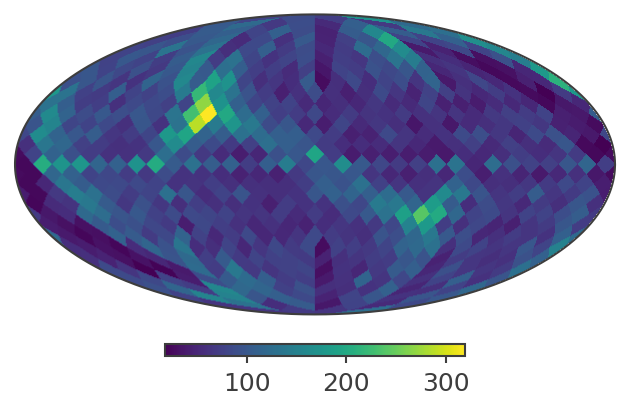

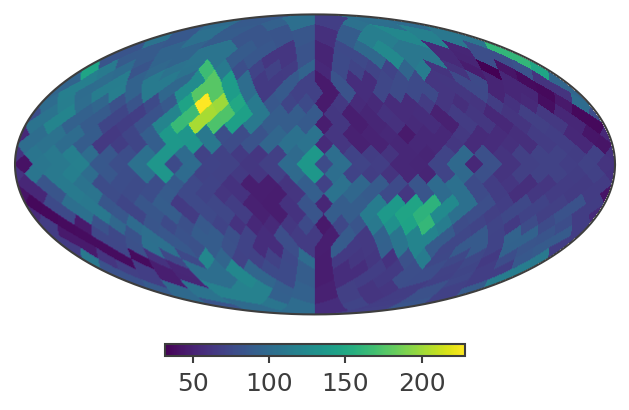

In [57]:
from mhealpy import HealpixMap, HealpixBase
from cosipy.response.FullDetectorResponse import FullDetectorResponse

spectrum.index.value = index
spectrum.K.value = K.value
spectrum.piv.value = piv.value

h = crab.binned_data.project('Em', 'Phi', 'PsiChi').slice[{'Em':2, 'Phi':4}].project('PsiChi')
m = HealpixMap(base = HealpixBase(npix = h.nbins), data = h.contents.todense())

_,ax = m.plot('mollview')

ax.scatter(-5.78, 184.56, color = 'red')

dwell_time_map = cosi._get_dwell_time_map(source.position.sky_coord)
psr = FullDetectorResponse.open(dr).get_point_source_response(dwell_time_map)

expectation = psr.get_expectation(spectrum).project(['Em', 'Phi', 'PsiChi']).slice[{'Em':2, 'Phi':4}].project('PsiChi') + 2.8e-4 * bkg.binned_data.project('Em', 'Phi', 'PsiChi').slice[{'Em':2, 'Phi':4}].project('PsiChi')

em = HealpixMap(base = HealpixBase(npix = expectation.nbins), data = expectation.contents.todense())

_,ax2 = em.plot('mollview')

#ax2.scatter(0, 70, transform=ax2.get_transform('world'), color = 'red')

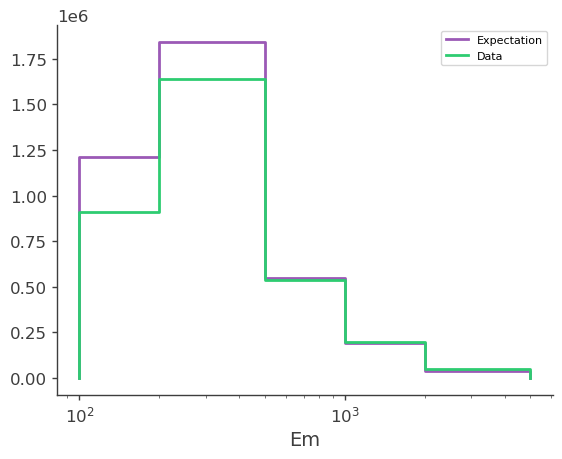

In [79]:
expectation = psr.get_expectation(spectrum)
ax, plot = expectation.project('Em').plot(label='Expectation')
crab.binned_data.project('Em').plot(ax, label='Data')
ax.legend()

## Read in data (source injector)

Load .h5 files from source injector

In [28]:
grb2 = Histogram.open("data/crabsignal.h5")
grb_bkg2 = Histogram.open("data/crabdata.h5")
bkg2 = Histogram.open("data/crabbkg.h5")

## Perform spectral fit (source injector)

Define inputs needed by COSI plugin, optionally set background parameter (fits amplitude of background), and instantiate threeML plugin

In [29]:
bkg_par2 = Parameter("background_cosi",                                       # background parameter
                    1,                                                        # initial value of parameter
                    min_value=0,                                              # minimum value of parameter
                    max_value=5,                                              # maximum value of parameter
                    delta=0.05,                                               # initial step used by fitting engine
                    desc="Background parameter for cosi")

cosi2 = COSILike("cosi",                                                      # COSI 3ML plugin
                dr = dr,                                                      # detector response
                data = grb_bkg2,                                              # data 
                bkg = bkg2,                                                   # background model 
                sc_orientation = sc_orientation,                              # spacecraft orientation
                nuisance_param = bkg_par2)                                    # background parameter

Define a point source at the known location with a power law spectrum and add it to the model

In [30]:
spectrum2 = Band()
alpha = -1.                                        # Setting parameters to something reasonable helps the fitting to converge
beta = -3.
xp = 1000 * u.keV
piv = 500 * u.keV
K = 0.00247 / u.cm / u.cm / u.s / u.keV
spectrum2.alpha.value = alpha
spectrum2.beta.value = beta
spectrum2.xp.value = xp.value
spectrum2.K.value = K.value
spectrum2.piv.value = piv.value
spectrum2.xp.unit = xp.unit
spectrum2.K.unit = K.unit
spectrum2.piv.unit = piv.unit

source2 = PointSource("source",                    # Name of source (arbitrary, but needs to be unique)
                     l = 51.,                      # Longitude (deg)
                     b = -17.,                     # Latitude (deg)
                     spectral_shape = spectrum2)   # Spectral model

model2 = Model(source2)                             # Model with single source. If we had multiple sources, we would do Model(source1, source2, ...)

# Optional: if you want to call get_log_like manually, then you also need to set the model manually
# 3ML does this internally during the fit though
cosi2.set_model(model2)

Gather all plugins and combine with model in JointLikelihood object, then perform maximum likelihood fit

In [31]:
plugins2 = DataList(cosi2) # If we had multiple instruments, we would do e.g. DataList(cosi, lat, hawc, ...)

like2 = JointLikelihood(model2, plugins2, verbose = False)

like2.fit()

17:06:49 INFO      set the minimizer to minuit                                             ]8;id=996190;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=650768;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING

17:06:57 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=591195;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=444323;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

Best fit values:

,result,unit
parameter,,
source.spectrum.main.Band.K,(2.47 -0.05 +0.06) x 10^-3,1 / (cm2 keV s)
source.spectrum.main.Band.alpha,-1.000 +/- 0.020,
source.spectrum.main.Band.xp,(1.000 -0.017 +0.018) x 10^3,keV
source.spectrum.main.Band.beta,-3.00 +/- 0.12,
background_cosi,1.00 +/- 0.16,


Correlation matrix:

1.00,0.94,-0.90,0.53,-0.05
0.94,1.00,-0.77,0.46,0.09
-0.90,-0.77,1.00,-0.62,0.00
0.53,0.46,-0.62,1.00,-0.02
-0.05,0.09,0.00,-0.02,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
cosi,-25804.500658
total,-25804.500658


Values of statistical measures:

,statistical measures
AIC,-51611.001317
BIC,-51609.001317


(                                      value  negative_error  positive_error  \
 source.spectrum.main.Band.K         0.00247       -0.000055        0.000055   
 source.spectrum.main.Band.alpha    -1.00000       -0.019215        0.019117   
 source.spectrum.main.Band.xp     1000.00000      -17.048129       17.510390   
 source.spectrum.main.Band.beta     -3.00000       -0.120826        0.119061   
 background_cosi                     1.00000       -0.157846        0.164867   
 
                                      error             unit  
 source.spectrum.main.Band.K       0.000055  1 / (cm2 keV s)  
 source.spectrum.main.Band.alpha   0.019166                   
 source.spectrum.main.Band.xp     17.279260              keV  
 source.spectrum.main.Band.beta    0.119943                   
 background_cosi                   0.161357                   ,
        -log(likelihood)
 cosi      -25804.500658
 total     -25804.500658)

## 3ML error propagation and plotting (source injector)

Define injected spectral parameters 

In [32]:
K_inj2 = 0.00247     # 1/keV/cm2/s
piv_inj2 = 500.      # keV
alpha_inj2 = -1.
beta_inj2 = -3.
xp_inj2 = 1000.      # keV 

The summary of the results above tell you the optimal values of the parameters, as well as the errors. You typically want to propagate these into the error in the flux at different energies, and plot the spectrum. Let's do that:

Best fit values:

,result,unit
parameter,,
source.spectrum.main.Band.K,(2.47 -0.05 +0.06) x 10^-3,1 / (cm2 keV s)
source.spectrum.main.Band.alpha,-1.000 +/- 0.020,
source.spectrum.main.Band.xp,(1.000 -0.017 +0.018) x 10^3,keV
source.spectrum.main.Band.beta,-3.00 +/- 0.12,
background_cosi,1.00 +/- 0.16,


Correlation matrix:

1.00,0.94,-0.90,0.53,-0.05
0.94,1.00,-0.77,0.46,0.09
-0.90,-0.77,1.00,-0.62,0.00
0.53,0.46,-0.62,1.00,-0.02
-0.05,0.09,0.00,-0.02,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
cosi,-25804.500658
total,-25804.500658


Values of statistical measures:

,statistical measures
AIC,-51611.001317
BIC,-51609.001317


None
  * source (point source):
    * position:
      * l:
        * value: 51.0
        * desc: Galactic longitude
        * min_value: 0.0
        * max_value: 360.0
        * unit: deg
        * is_normalization: false
      * b:
        * value: -17.0
        * desc: Galactic latitude
        * min_value: -90.0
        * max_value: 90.0
        * unit: deg
        * is_normalization: false
      * equinox: J2000
    * spectrum:
      * main:
        * Band:
          * K:
            * value: 0.0024700000000000407
            * desc: Differential flux at the pivot energy
            * min_value: 1.0e-99
            * max_value: null
            * unit: keV-1 s-1 cm-2
            * is_normalization: true
          * alpha:
            * value: -1.0
            * desc: low-energy photon index
            * min_value: -1.5
            * max_value: 3.0
            * unit: ''
            * is_normalization: false
          * xp:
            * value: 1000.000000000001
            * desc:

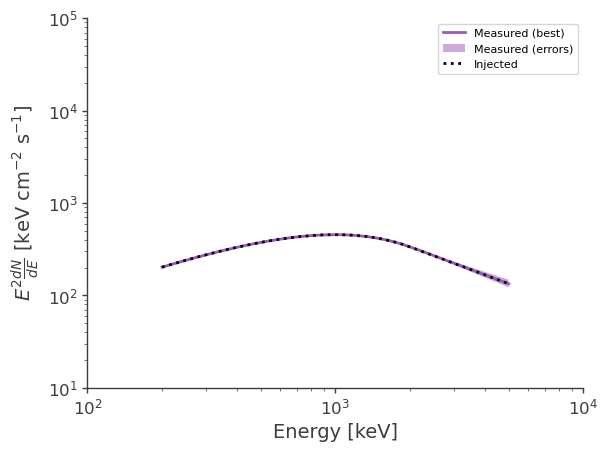

In [33]:
# Propagate the errors to the "evaluate_at" method of the spectrum
results = like2.results

print(results.display())

parameters = {par.name:results.get_variates(par.path)
               for par in results.optimized_model["source"].parameters.values()
               if par.free}

if 'l' in parameters:
    del parameters['l']
if 'b' in parameters:
    del parameters['b']

results_err = results.propagate(results.optimized_model["source"].spectrum.main.shape.evaluate_at, **parameters)

print(results.optimized_model["source"])

# Evaluate at multiple energy values, for plotting
energy = np.geomspace(200*u.keV,5*u.MeV).to_value(u.keV)

flux_lo = np.zeros_like(energy)
flux_median = np.zeros_like(energy)
flux_hi = np.zeros_like(energy)

for i, e in enumerate(energy):
    flux = results_err(e)
    flux_median[i] = flux.median
    flux_lo[i], flux_hi[i] = flux.equal_tail_interval(cl=0.68)
    
# Plot
fig,ax = plt.subplots()

ax.plot(energy, energy*energy*flux_median, label = "Measured (best)")

ax.fill_between(energy, energy*energy*flux_lo, energy*energy*flux_hi, alpha = .5, label = "Measured (errors)")

# Plot injected spectrum
def band_megalib(energy, alpha, beta, E0):
    if energy == 0 or alpha - beta < 0:
        return 0.0
    else:
        ebreak = (alpha - beta) * E0
        if energy <= ebreak:
            return energy**alpha * np.exp(-energy/E0)
        else:
            return ebreak**(alpha-beta) * np.exp(beta-alpha) * energy**beta

flux_inj = np.zeros_like(energy)

for i, e in enumerate(energy):
    flux_inj[i] = K_inj * band_megalib(e, alpha_inj, beta_inj, xp_inj)
ax.plot(energy, energy*energy*flux_inj, color = 'black', ls = ":", label = "Injected")

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlim(1e2, 1e4)
ax.set_ylim(10, 1e5)

ax.set_xlabel("Energy [keV]")
ax.set_ylabel(r"$E^2 \frac{dN}{dE}$ [keV cm$^{-2}$ s$^{-1}$]")

ax.legend()